In [1]:
import seaborn as sns
import pandas as pd
import kneed
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from time import time
import numpy as np


## Experimental parameters

In [ ]:
# biasDegree = 
# classImbalanceDegree = 
sizeOfLabeledSet = 0.025
# biasMechanism = 


# Import data

In [2]:
def read_file(url):

    url = url + "?raw=true"
    df = pd.read_csv(url, encoding='cp1252', sep=',', low_memory=False)
    return df

In [3]:
url = "https://github.com/hannahgathu/Thesis-Data-Visualisations/blob/main/Data/dielectron_classification.csv"

df= read_file(url)

# Visualize data

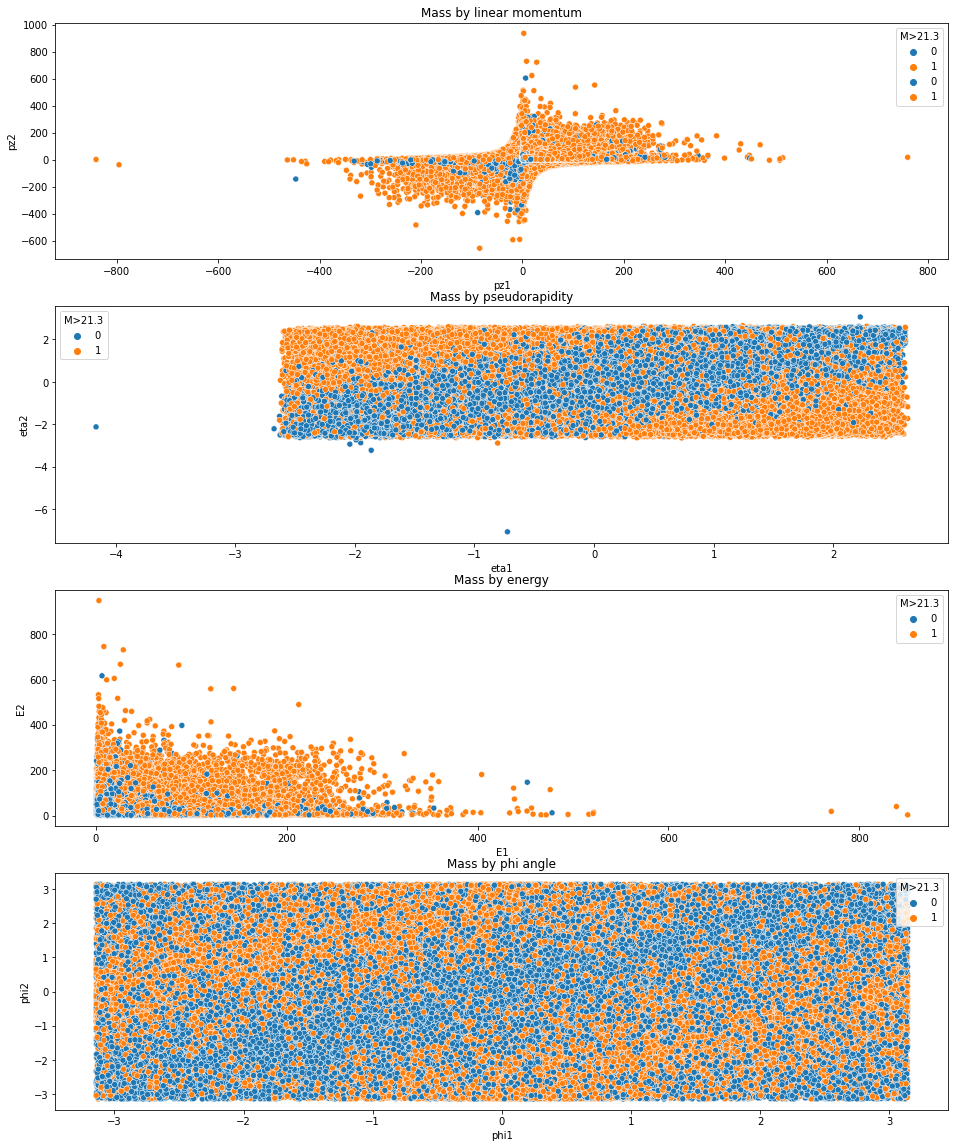

In [4]:
fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(16,20))

sns.scatterplot(ax= ax[0],data=df, x='pz1', y='pz2', hue='M>21.3')
ax[0].set_title('pz1 and pz2')
sns.scatterplot(ax= ax[0],data=df, x='pt1', y='pt2', hue='M>21.3')
ax[0].set_title('Mass by linear momentum')
sns.scatterplot(ax= ax[1],data=df, x='eta1', y='eta2', hue='M>21.3')
ax[1].set_title('Mass by pseudorapidity')
sns.scatterplot(ax= ax[2],data=df, x='E1', y='E2', hue='M>21.3')
ax[2].set_title('Mass by energy')
sns.scatterplot(ax= ax[3],data=df, x='phi1', y='phi2', hue='M>21.3')
ax[3].set_title('Mass by phi angle')

plt.show()

# Add noise

In [7]:
def add_noise (std, data):
    for i in range(data.shape[0]):
        data.at[i,'M']=data.iloc[i].loc['M']+np.random.normal(0,std)
    return data

In [8]:
df_noise=add_noise(0,3,df)

# Transform to classification problem

In [9]:
    for i in range(df_noise.shape[0]):
        df_noise.at[i,'M>21.3']=int(df_noise.iloc[i].loc['M']>21.3)

# Train classifier on noisy data

In [59]:
#split data
y_noise=df_noise.M>21.3
#additional to dropping the endpoints we also drop the run and event numbers, because those aren't predictors
X=df.drop(columns=['M>21.3','M','Run','Event'])
X_train_noise, X_test_noise, y_train_noise, y_test_noise = train_test_split(X,y_noise,test_size=0.3, random_state=42)

#train rf
rf = RandomForestClassifier()
t0 = time()
rf.fit(X_train_noise, y_train_noise)
print ('training time: ', round(time()-t0, 3), 's')

#calculate accuracy
t1=time()
pred_rf_noise = rf.predict(X_test_noise)
print ('predicting time: ', round(time()-t1, 3), 's')
print("Accuracy:",metrics.accuracy_score(y_test_noise, pred_rf_noise))

training time:  56.089 s
predicting time:  1.386 s
Accuracy: 0.9263666666666667


# Add bias

## Train classifier on whole dataset

### Prep and split data

In [ ]:
y=df_noise.M>21.3
#additional to dropping the endpoints we also drop the run and event numbers, because those aren't predictors
X=df_noise.drop(columns=['M>21.3','M','Run','Event'])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)
#X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(X,y,test_size=0.2, random_state=42)

### Tune hyperparameters

In [ ]:
rf = RandomForestClassifier()
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

**Create random hyperparameter grid** 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

**Random search training**

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_20, y_train_20)

In [ ]:
rf_random.best_params_

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = metrics.accuracy_score(test_labels, predictions)
    print('Model Performance')
    print('Accuracy =', accuracy)
    
    return accuracy

base_model = RandomForestClassifier(random_state = 42)
base_model.fit(X_train_10, y_train_10)
base_accuracy = evaluate(base_model, X_test_10, y_test_10)
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test_10, y_test_10)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


In [ ]:
base_model_2 = RandomForestClassifier(random_state = 42)
base_model_2.fit(X_train_2, y_train_2)
base_accuracy = evaluate(base_model_2, X_test_2, y_test_2)

In [ ]:
rf_random_2 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random_2.fit(X_train_2, y_train_2)

In [ ]:
rf_random_2.best_params_

In [ ]:
base_accuracy_2 = base_accuracy
best_random_2 = rf_random_2.best_estimator_
random_accuracy_2 = evaluate(best_random_2, X_test_2, y_test_2)
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy_2 - base_accuracy_2) / base_accuracy_2))

### Train RF classifier

In [ ]:
rf = RandomForestClassifier()
t0 = time()
rf.fit(X, y)
print ('training time: ', round(time()-t0, 3), 's')

In [ ]:
t1=time()
pred_rf = rf.predict(X)
print ('predicting time: ', round(time()-t1, 3), 's')
print("Accuracy:",metrics.accuracy_score(y, pred_rf))

### Calculate accuracy

In [ ]:
t1=time()
pred_rf = rf.predict(X_test)
print ('predicting time: ', round(time()-t1, 3), 's')
print("Accuracy:",metrics.accuracy_score(y_test, pred_rf))

### Get probabilities

In [11]:
pred = rf.predict(X)
prob = rf.predict_proba(X)

### Get prob files

In [12]:
predictions_noise_12_100 = pd.DataFrame(X)
predictions_noise_12_100['pred'] = pred
predictions_noise_12_100['prob1'] = prob[:,1]
predictions_noise_12_100.to_csv('predictions_noise_12_100.csv')

## Bin data

In [13]:
pd.qcut(predictions_noise_12_100['prob1'], q=7)

0        (-0.001, 0.01]
1          (0.05, 0.19]
2          (0.96, 0.99]
3        (-0.001, 0.01]
4          (0.01, 0.05]
              ...      
99995    (-0.001, 0.01]
99996      (0.19, 0.84]
99997      (0.01, 0.05]
99998    (-0.001, 0.01]
99999      (0.84, 0.96]
Name: prob1, Length: 100000, dtype: category
Categories (7, interval[float64]): [(-0.001, 0.01] < (0.01, 0.05] < (0.05, 0.19] < (0.19, 0.84] < (0.84, 0.96] < (0.96, 0.99] < (0.99, 1.0]]

In [14]:
def bin_data (data, number_of_bins):
    dict_bins = pd.Series.to_dict(pd.qcut(data, q=number_of_bins, labels=False))
    return dict_bins

In [15]:
predictions_noise_12_100_binned = bin_data(predictions_noise_12_100['prob1'], 7)

## Calculate bin distribution

In [ ]:
# Might want to move this to a separate file

In [16]:
def get_bin_distribution(a,k):
    distribution = []
    for x in range (1,8):
        f_x = a*(x-4)**2+k
        distribution.append(f_x)    
    print (sum(distribution))
    for i in range (7):
        distribution[i]=distribution[i]/sum(distribution)        
    return distribution

In [17]:
distribution_002_005 = get_bin_distribution(1/45,0.05)

0.9722222222222223


In [82]:
distribution_001_010 = get_bin_distribution(1/93,0.1)

1.0010752688172042


In [19]:
sum(distribution_001_010)

1.0003629088716226

In [20]:
distribution_004_000 = get_bin_distribution(1/28,0)

1.0


## Pick sample

In [21]:
import random
import math

#this function returns the dataframe with a new column that indicates whether an instance is in the sample or not.
def get_sample(sample_size, distribution, data_binned, df):
    
    #ugly for now, a new dataframe that has a column for whether an instance is in the sample or not
    df_sampled = df
    in_sample = [0]* df_sampled.shape[0]
    print(len(in_sample))
    
    indices=[]
    for bin in range (7):
        pool = []
        for i in range (len(data_binned)):
            if data_binned[i]==bin:
                pool.append(i)
        indices.extend(random.sample(pool , math.ceil(distribution[bin]*sample_size)))
    sample = []
    for i in indices:
        sample.append(df.iloc[[i]])
        in_sample[i]=1
    df_sampled['in_biased_sample']=in_sample     
    #return pd.concat(sample)
    return df_sampled

In [ ]:
sample_002_005 = get_sample(3000, d, predictions_10_binned, df)

In [22]:
sample_004_000 = get_sample(700, distribution_004_000, predictions_10_binned, df)

NameError: name 'predictions_10_binned' is not defined

In [ ]:
CERN_sampled_004_000 = get_sample(3000, distribution_004_000, predictions_10_binned, df)

In [ ]:
CERN_sampled_004_000.shape

In [ ]:
CERN_sampled_004_000.to_csv('CERN_sampled_rf_0.1_dis_004_000.csv')

In [93]:
#done:
CERN_noise_sampled_004_000_700 = get_sample(700, distribution_004_000, predictions_noise_12_100_binned, df)

100000


In [69]:
distribution_01_n02=[0.39,0.11,0,0,0,0.11,0.39]

In [86]:
CERN_noise_sampled_01_n02_700 = get_sample(700, distribution_01_n02, predictions_noise_12_100_binned, df)

100000


In [98]:
f=CERN_noise_sampled_004_000_700[CERN_noise_sampled_004_000_700['in_biased_sample']==1]

In [99]:
f.head()

,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,...,px2,py2,pz2,pt2,eta2,phi2,Q2,M>21.3,M,in_biased_sample
385,147115,256747115,12.75900,2.285630,-2.305520,12.339100,3.246460,2.045230,-0.789730,-1,...,-11.302100,11.73460,77.0914,16.29230,2.25843,2.33742,-1,0,8.219835,1
438,147115,195689670,11.02420,1.482380,-3.509360,10.345100,3.809600,1.724430,-1.171120,1,...,-2.809160,-2.83157,13.5638,3.98863,1.93805,-2.35222,1,0,8.381767,1
462,147115,198354697,1.20585,0.122434,0.866619,0.829485,0.875225,0.843933,1.430450,1,...,0.567601,14.42420,-27.8788,14.43540,-1.41247,1.53147,1,0,11.971700,1
535,147115,524711834,3.31555,1.675950,-2.535970,1.323970,3.039730,0.422842,-0.986817,1,...,2.846600,-1.33658,-12.7853,3.14476,-2.11050,-0.43898,1,0,9.054852,1
666,147115,218941723,196.61400,33.703000,9.377630,193.477000,34.983300,2.411510,0.271379,-1,...,-35.007700,-12.69540,55.8596,37.23860,1.19479,-2.79370,1,1,89.144986,1


In [96]:
g=CERN_noise_sampled_01_n02_700[CERN_noise_sampled_01_n02_700['in_biased_sample']==1]

In [97]:
g.head()

,Run,Event,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,...,px2,py2,pz2,pt2,eta2,phi2,Q2,M>21.3,M,in_biased_sample
385,147115,256747115,12.75900,2.285630,-2.305520,12.339100,3.246460,2.045230,-0.789730,-1,...,-11.302100,11.73460,77.0914,16.29230,2.25843,2.33742,-1,0,8.219835,1
438,147115,195689670,11.02420,1.482380,-3.509360,10.345100,3.809600,1.724430,-1.171120,1,...,-2.809160,-2.83157,13.5638,3.98863,1.93805,-2.35222,1,0,8.381767,1
462,147115,198354697,1.20585,0.122434,0.866619,0.829485,0.875225,0.843933,1.430450,1,...,0.567601,14.42420,-27.8788,14.43540,-1.41247,1.53147,1,0,11.971700,1
535,147115,524711834,3.31555,1.675950,-2.535970,1.323970,3.039730,0.422842,-0.986817,1,...,2.846600,-1.33658,-12.7853,3.14476,-2.11050,-0.43898,1,0,9.054852,1
666,147115,218941723,196.61400,33.703000,9.377630,193.477000,34.983300,2.411510,0.271379,-1,...,-35.007700,-12.69540,55.8596,37.23860,1.19479,-2.79370,1,1,89.144986,1


In [ ]:
CERN_noise_sampled_004_000_700.to_csv('CERN_sampled_rf_0.1_dis_004_000_700.csv')

## Visualize sample

In [ ]:
fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(16,20))

sns.scatterplot(ax= ax[0],data=sample_002_005, x='pt1', y='pt2', hue='M>21.3')
ax[0].set_title('Mass by linear momentum')
sns.scatterplot(ax= ax[1],data=sample_002_005, x='eta1', y='eta2', hue='M>21.3')
ax[1].set_title('Mass by pseudorapidity')
sns.scatterplot(ax= ax[2],data=sample_002_005, x='E1', y='E2', hue='M>21.3')
ax[2].set_title('Mass by energy')
sns.scatterplot(ax= ax[3],data=sample_002_005, x='phi1', y='phi2', hue='M>21.3')
ax[3].set_title('Mass by phi angle')

plt.show()

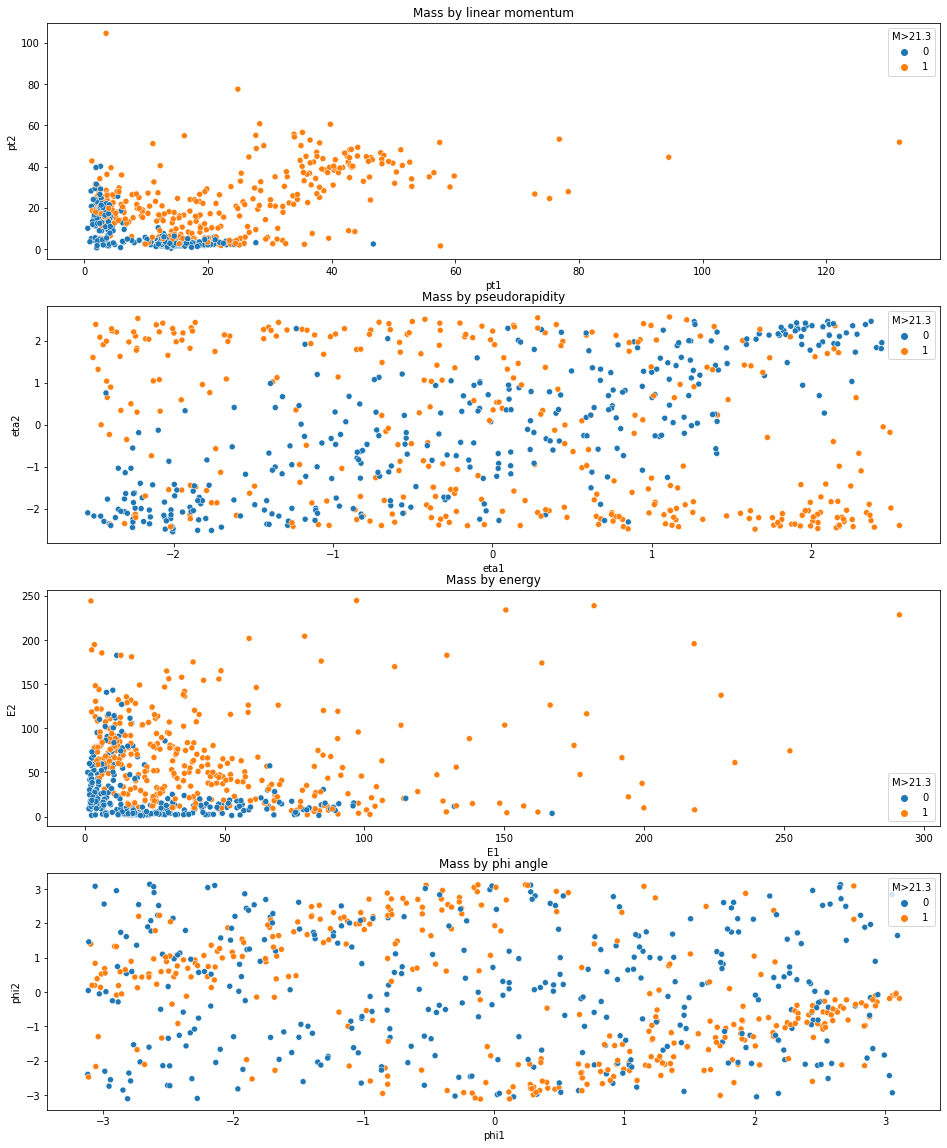

In [74]:
fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(16,20))

sns.scatterplot(ax= ax[0],data=CERN_noise_sampled_004_000_700[CERN_noise_sampled_004_000_700['in_biased_sample']==1], x='pt1', y='pt2', hue='M>21.3')
ax[0].set_title('Mass by linear momentum')
sns.scatterplot(ax= ax[1],data=CERN_noise_sampled_004_000_700[CERN_noise_sampled_004_000_700['in_biased_sample']==1], x='eta1', y='eta2', hue='M>21.3')
ax[1].set_title('Mass by pseudorapidity')
sns.scatterplot(ax= ax[2],data=CERN_noise_sampled_004_000_700[CERN_noise_sampled_004_000_700['in_biased_sample']==1], x='E1', y='E2', hue='M>21.3')
ax[2].set_title('Mass by energy')
sns.scatterplot(ax= ax[3],data=CERN_noise_sampled_004_000_700[CERN_noise_sampled_004_000_700['in_biased_sample']==1], x='phi1', y='phi2', hue='M>21.3')
ax[3].set_title('Mass by phi angle')

plt.show()

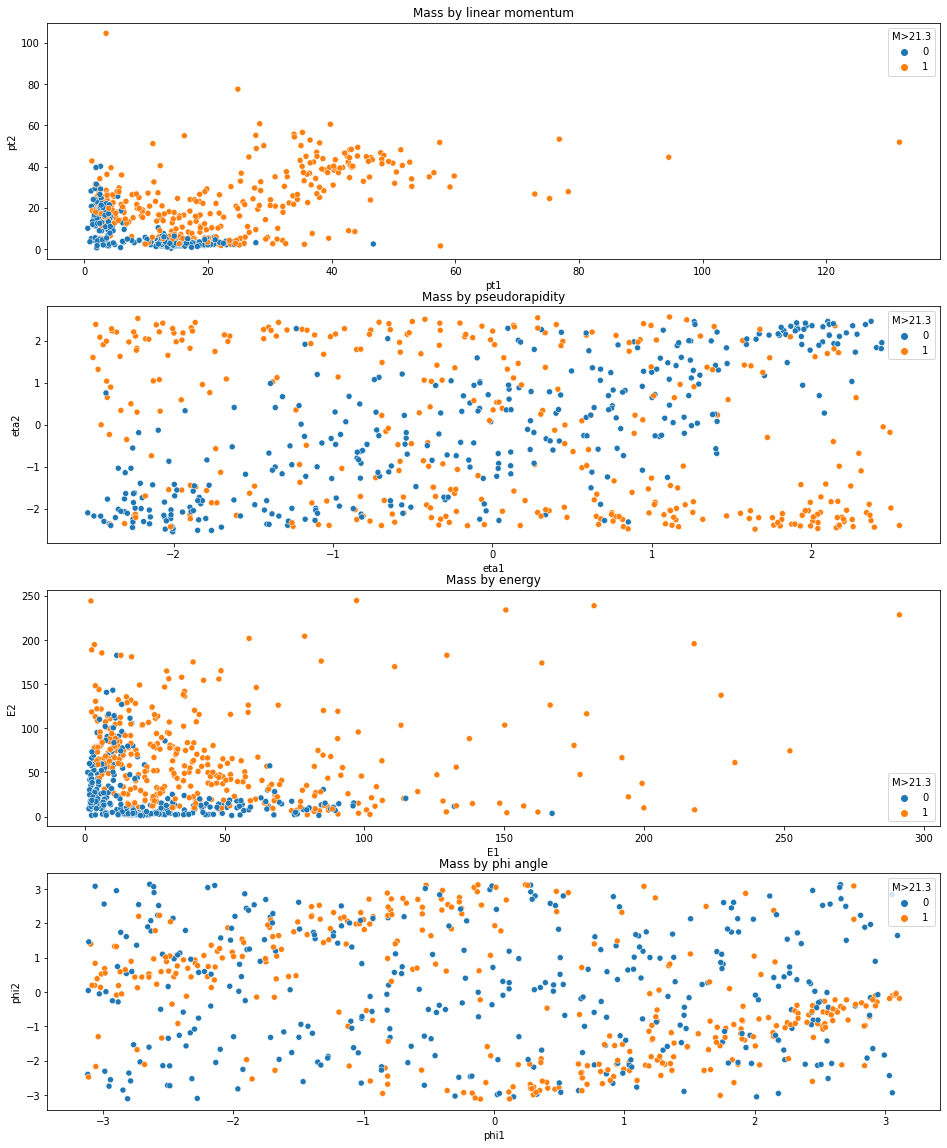

In [75]:
fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(16,20))

sns.scatterplot(ax= ax[0],data=CERN_noise_sampled_01_n02_700[CERN_noise_sampled_01_n02_700['in_biased_sample']==1], x='pt1', y='pt2', hue='M>21.3')
ax[0].set_title('Mass by linear momentum')
sns.scatterplot(ax= ax[1],data=CERN_noise_sampled_01_n02_700[CERN_noise_sampled_01_n02_700['in_biased_sample']==1], x='eta1', y='eta2', hue='M>21.3')
ax[1].set_title('Mass by pseudorapidity')
sns.scatterplot(ax= ax[2],data=CERN_noise_sampled_01_n02_700[CERN_noise_sampled_01_n02_700['in_biased_sample']==1], x='E1', y='E2', hue='M>21.3')
ax[2].set_title('Mass by energy')
sns.scatterplot(ax= ax[3],data=CERN_noise_sampled_01_n02_700[CERN_noise_sampled_01_n02_700['in_biased_sample']==1], x='phi1', y='phi2', hue='M>21.3')
ax[3].set_title('Mass by phi angle')

plt.show()

In [ ]:
CERN_sampled_004_000_700

In [56]:
y_bias=CERN_noise_sampled_004_000_700[CERN_noise_sampled_004_000_700['in_biased_sample']==1].M>21.3
#y_bias_50=CERN_noise_sampled_004_000_50[CERN_noise_sampled_004_000_50['in_biased_sample']==1].M>21.3
#additional to dropping the endpoints we also drop the run and event numbers, because those aren't predictors
X_bias=CERN_noise_sampled_004_000_700[CERN_noise_sampled_004_000_700['in_biased_sample']==1].drop(columns=['M>21.3','M','Run','Event'])

X_train_bias, X_test_bias, y_train_bias, y_test_bias = train_test_split(X_bias,y_bias,test_size=0.3, random_state=42)

In [57]:
X_bias.shape[0]

700

In [58]:
#train rf
rf_bias = RandomForestClassifier()
t0 = time()
rf_bias.fit(X_train_bias, y_train_bias)
print ('training time: ', round(time()-t0, 3), 's')

#calculate accuracy on sample
t1=time()
pred_rf_bias = rf_bias.predict(X_test_bias)
print ('predicting time: ', round(time()-t1, 3), 's')
print("Accuracy:",metrics.accuracy_score(y_test_bias, pred_rf_bias))

training time:  0.306 s
predicting time:  0.03 s
Accuracy: 0.9428571428571428


In [103]:
print(classification_report(y_test_bias, pred_rf_bias))

              precision    recall  f1-score   support

       False       0.94      0.94      0.94       108
        True       0.94      0.94      0.94       102

    accuracy                           0.94       210
   macro avg       0.94      0.94      0.94       210
weighted avg       0.94      0.94      0.94       210



In [61]:
#calculate accuracy on whole set
t1=time()
pred_rf_bias_whole = rf_bias.predict(X)
print ('predicting time: ', round(time()-t1, 3), 's')
print("Accuracy:",metrics.accuracy_score(y_noise, pred_rf_bias_whole))

predicting time:  1.873 s
Accuracy: 0.81809


In [106]:
print(classification_report(y_noise, pred_rf_bias_whole))

              precision    recall  f1-score   support

       False       0.80      0.84      0.82     49421
        True       0.83      0.80      0.82     50579

    accuracy                           0.82    100000
   macro avg       0.82      0.82      0.82    100000
weighted avg       0.82      0.82      0.82    100000



In [108]:
metrics.roc_auc_score(y_test_bias, pred_rf_bias)

0.9428104575163399

In [109]:
metrics.roc_auc_score(y_noise, pred_rf_bias_whole)

0.8183073102644002